In [4]:
import pandas as pd
import graspologic as gp
import seaborn as sns
import hyppo
import matplotlib.pyplot as plt
import numpy as np

import plotly.graph_objects as go
import matplotlib.cm

from sklearn.preprocessing import LabelEncoder

from graspologic.embed import OmnibusEmbed, select_svd

import plotly.io as pio
pio.renderers.default="png"

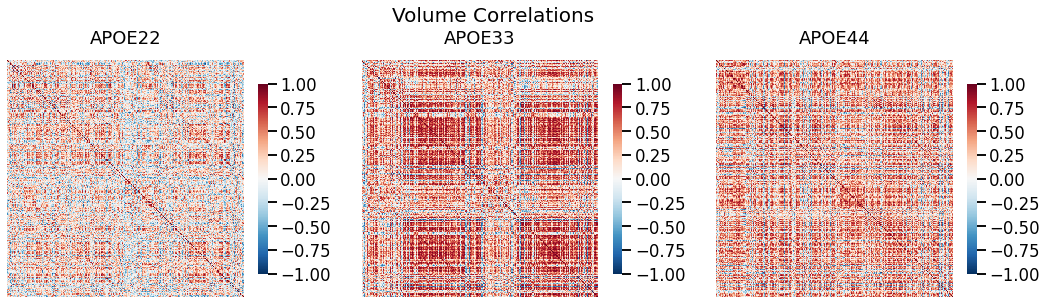

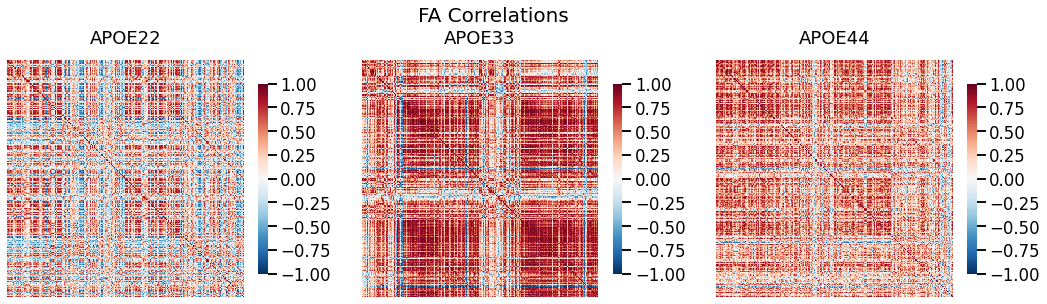

In [5]:
## Read the data

key = pd.read_csv('../data/processed/key.csv')
data = pd.read_csv('../data/processed/mouses-volumes.csv')
fa = pd.read_csv('../data/processed/mouses-fa.csv')

data.set_index(key.DWI, inplace=True)
fa.set_index(key.DWI, inplace=True)

genotypes = ['APOE22', 'APOE33', 'APOE44']


gen_animals = {genotype: None for genotype in genotypes}

for genotype in genotypes:
    gen_animals[genotype] = key.loc[key['Genotype'] == genotype]['DWI'].tolist()

vol_dat = {genotype: [] for genotype in genotypes}
fa_dat = {genotype: [] for genotype in genotypes}
for genotype in genotypes:
    vol_dat[genotype] = data.loc[gen_animals[genotype]].to_numpy()
    fa_dat[genotype] = fa.loc[gen_animals[genotype]].to_numpy()
    
## Compute correlations
vol_cor = {genotype: gp.utils.symmetrize(np.corrcoef(dat, rowvar=False)) for (genotype, dat) in vol_dat.items()}
fa_cor = {genotype: gp.utils.symmetrize(np.corrcoef(dat, rowvar=False)) for (genotype, dat) in fa_dat.items()}

## Plot to make sure nothing is wrong

fig, ax = plt.subplots(1, 3, figsize=(18, 5))
for (i, genotype) in enumerate(vol_cor.keys()):
    fig.suptitle("Volume Correlations", fontsize=20)
    gp.plot.heatmap(vol_cor[genotype], title=genotype, ax=ax[i], vmin=-1, vmax=1)

fig, ax = plt.subplots(1, 3, figsize=(18, 5))
for (i, genotype) in enumerate(fa_cor.keys()):
    fig.suptitle("FA Correlations",  fontsize=20)
    gp.plot.heatmap(fa_cor[genotype], title=genotype, ax=ax[i], vmin=-1, vmax=1)
    
    

## Node hierarchical label data
node_labels = pd.read_csv("../data/processed/node_label_dictionary.csv")

## Test whether brain volume and FA are independent

If FA and brain volume values are independent, it suggest that FA does not contain any information about brain volume, suggesting that using FA should not yield any different results

In [6]:
pvals = []

for genotype in genotypes:
    dcorr = hyppo.independence.Dcorr()
    stat, pval = dcorr.test(vol_dat[genotype].T, fa_dat[genotype].T)
    pvals.append([genotype, pval])
    
pval_df = pd.DataFrame(pvals, columns=["Genotype", "P-value"])

pval_df

Genotype   P-value
0   APOE22  0.000121
1   APOE33  0.000197
2   APOE44  0.000104

These p-values suggest that FA and brain volume are depedent.

### Testing whether brain volume and FA correlations are independent

Similar analysis, but we are evaluating the correlations

In [7]:
pvals = []

for genotype in genotypes:
    dcorr = hyppo.independence.Dcorr(compute_distance=None)
    stat, pval = dcorr.test(vol_cor[genotype].T, fa_cor[genotype].T)
    pvals.append([genotype, pval])
    
pval_df = pd.DataFrame(pvals, columns=["Genotype", "P-value"])

pval_df

Genotype   P-value
0   APOE22  0.000117
1   APOE33  0.000002
2   APOE44  0.000253

Again, the p-values suggest that brain volume and FA correlations are not independent

## Using omnibus embedding and multiple adjacency spectral embedding to simulataneously embed brain volume and FA

In [8]:
omni = OmnibusEmbed()

embeddings = [omni.fit_transform([vol_cor[genotype], fa_cor[genotype]])[0] for genotype in genotypes]

embeddings = np.hstack(embeddings)

In [9]:
embeddings.shape

(332, 13)

In [10]:
U, D, V = select_svd(embeddings)

In [11]:
D.shape

(2,)

### Hierarchical clustering on the embeddings

In [12]:
cluster = gp.cluster.DivisiveCluster(max_level=3)

cluster_labels = cluster.fit_predict(U, fcluster=True)

cluster_label_df = pd.DataFrame(cluster_labels, columns=["cluster_level_1", "cluster_level_2", "cluster_level_3"])

In [13]:
def count_groups(label_matrix):
    levels = label_matrix.shape[1] - 1
    d = []

    for level in range(levels):
        upper_cluster_ids = np.unique(label_matrix[:, level])
        
        for upper_cluster_id in upper_cluster_ids:
            lower_cluster_ids, counts = np.unique(
                label_matrix[label_matrix[:, level] == upper_cluster_id][:, level + 1], return_counts=True
            )

            for idx, lower_cluster_id in enumerate(lower_cluster_ids):
                if upper_cluster_id == lower_cluster_id:
                    lower_cluster_id = None
                d.append((upper_cluster_id, lower_cluster_id, counts[idx]))

    d = np.array(d)
    
    source = d[:, 0]
    target = d[:, 1]
    value = d[:, 2]
    
    return source, target, value

def append_apriori_labels(apriori_labels, cluster_matrix):
    encoder = LabelEncoder()
    apriori_labels_encoded = encoder.fit_transform(apriori_labels)
    apriori_labels_encoded = apriori_labels_encoded.reshape(-1, 1)
    
    # Increase the original cluster_matrix labels
    cluster_matrix_ = cluster_matrix + np.max(apriori_labels_encoded) + 1
    
    out = np.hstack([apriori_labels_encoded, cluster_matrix_])
    
    return out, list(encoder.classes_)

hemispheric_clusters, encoded_labels = append_apriori_labels(node_labels.Hemisphere, cluster_labels)

source, target, value = count_groups(hemispheric_clusters)

## Visualizing Sankey

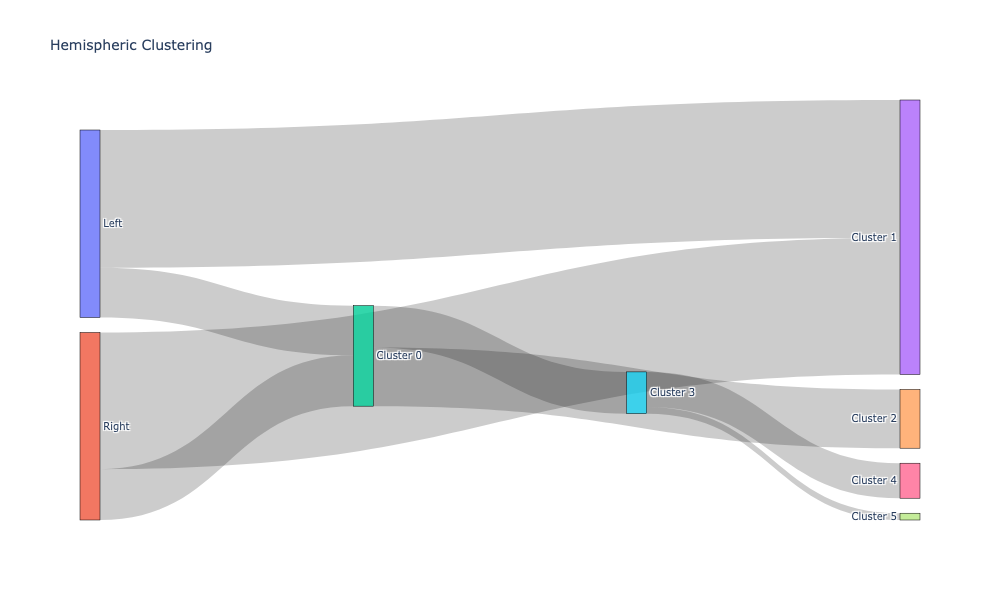

In [15]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = encoded_labels + [f"Cluster {i}" for i in range(np.max(hemispheric_clusters))]
    ),
    link = dict(
      source = source,
      target = target,
      value = value
  ))])

fig.update_layout(title_text="Hemispheric Clustering", font_size=10)
fig.show(dpi=300, width=1000, height=600)

In [16]:
level_1_clusters, encoded_labels = append_apriori_labels(node_labels.Level_1, cluster_labels)

source, target, value = count_groups(level_1_clusters)

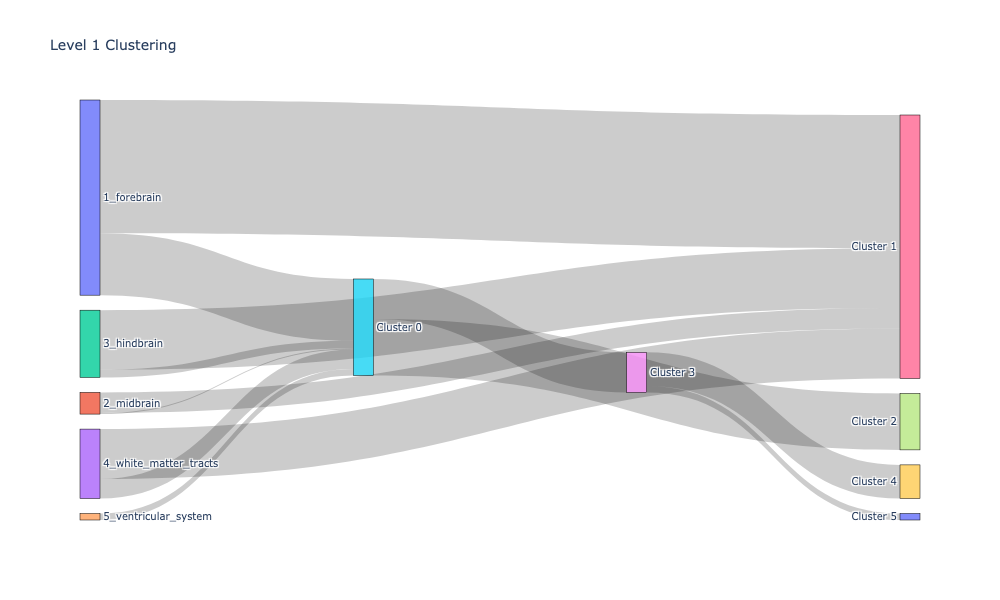

In [17]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = encoded_labels + [f"Cluster {i}" for i in range(np.max(level_1_clusters[0]))],
    ),
    link = dict(
      source = source,
      target = target,
      value = value
  ))])

fig.update_layout(title_text="Level 1 Clustering", font_size=10)
fig.show(dpi=300, width=1000, height=600)

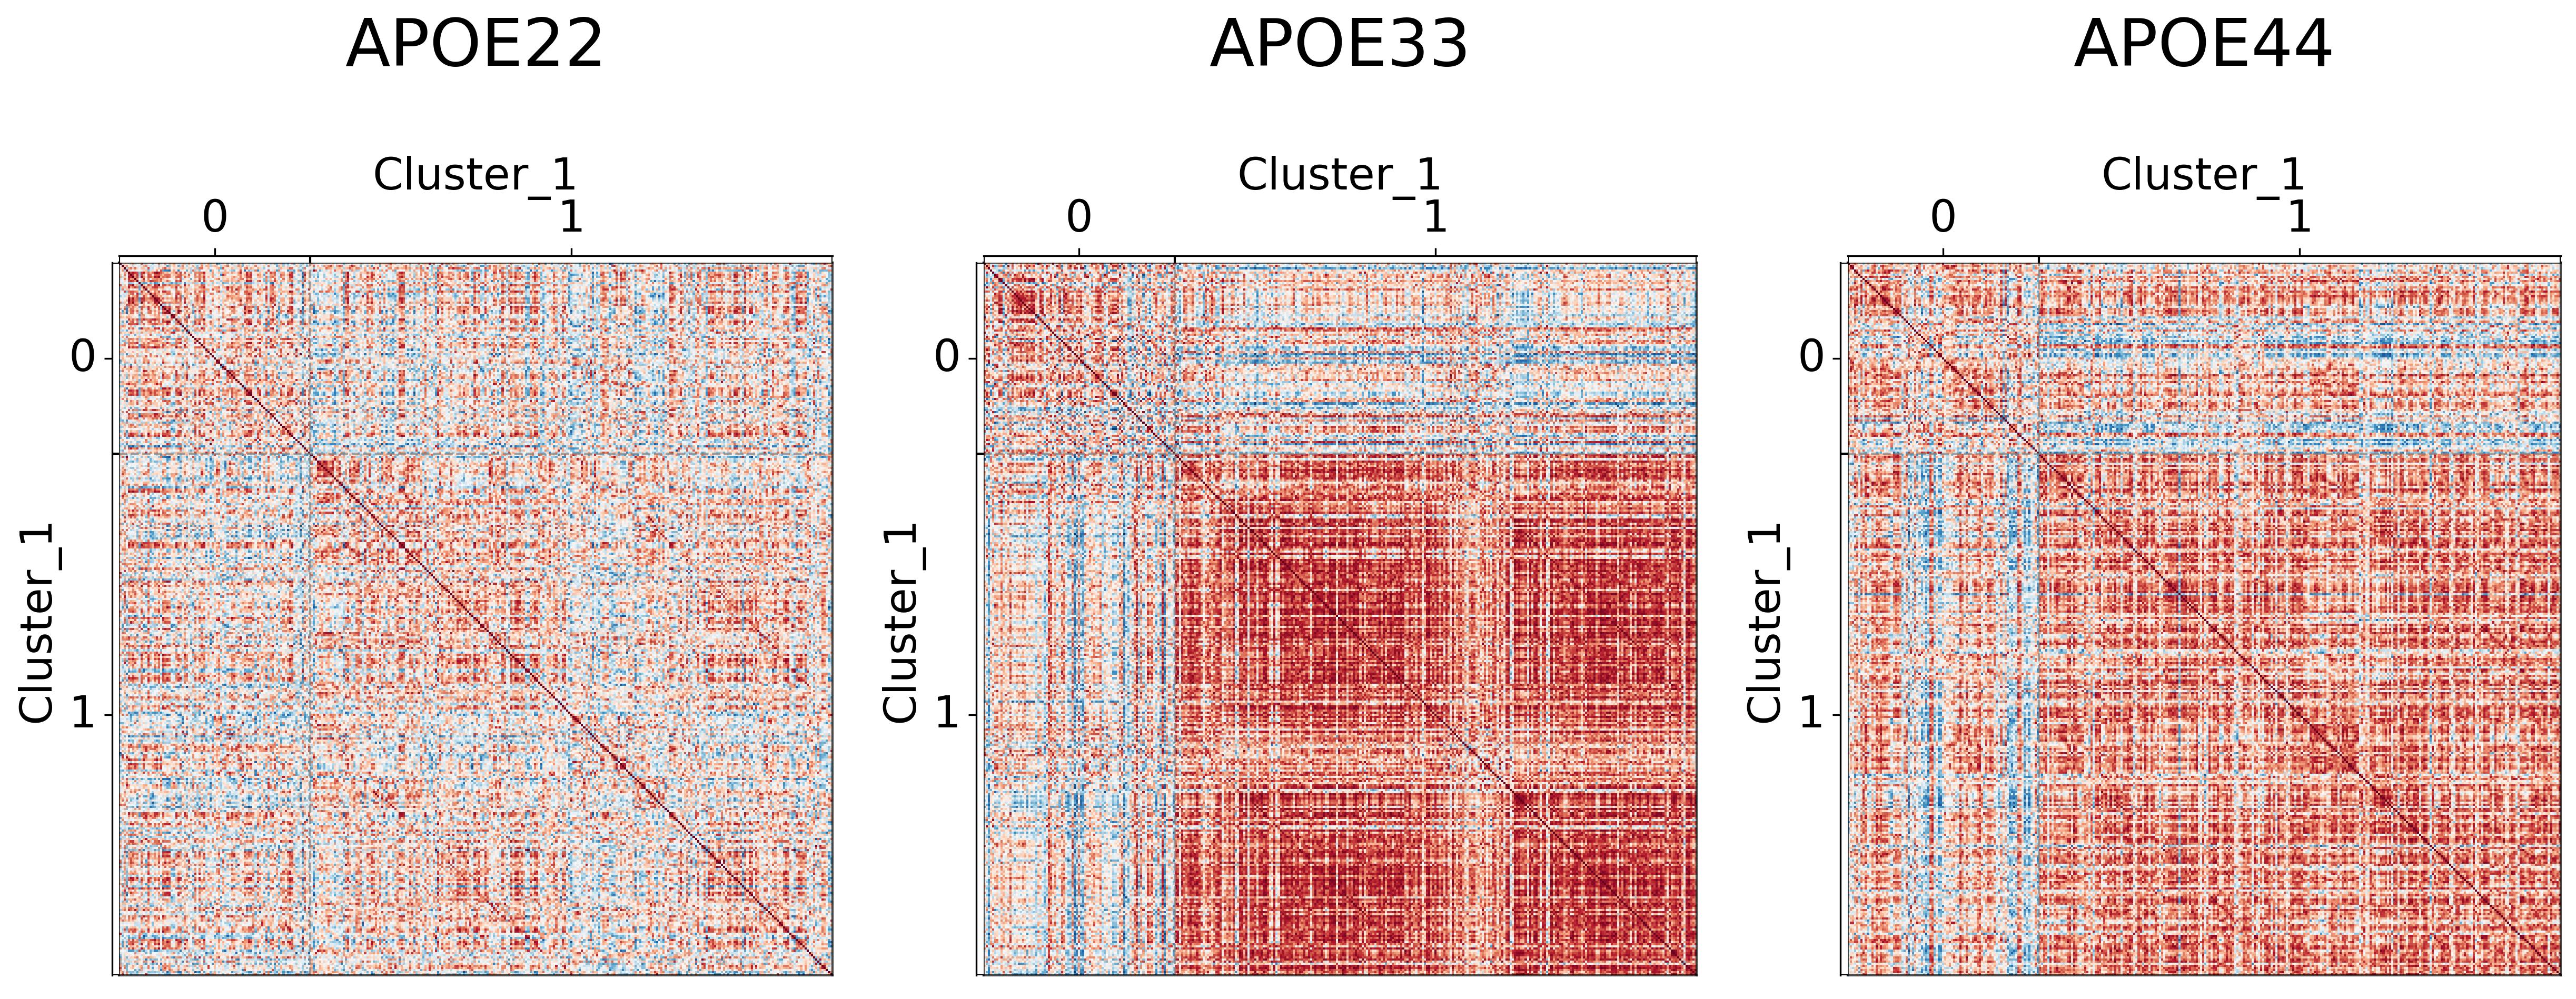

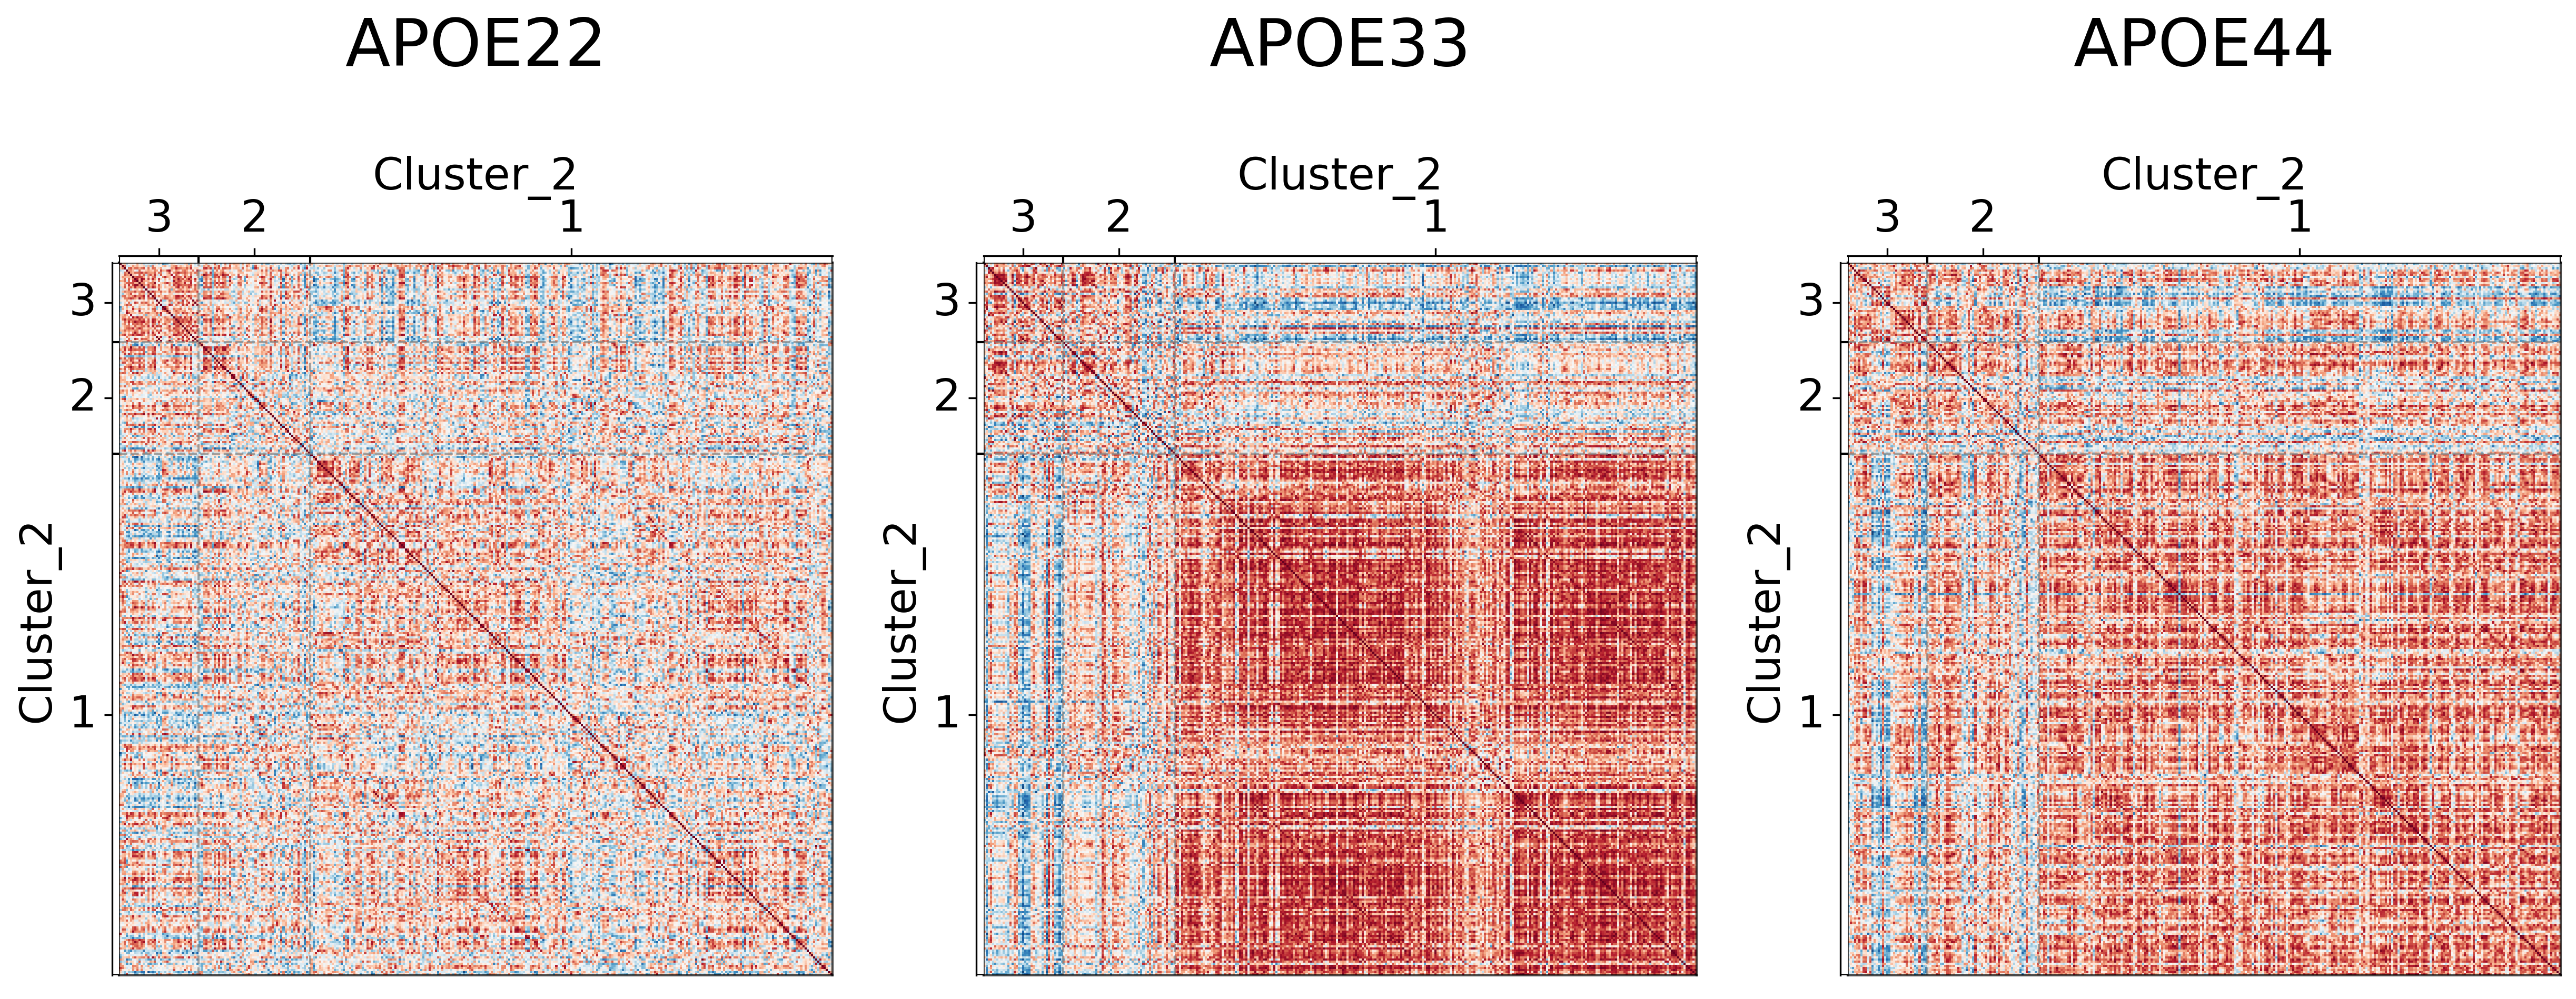

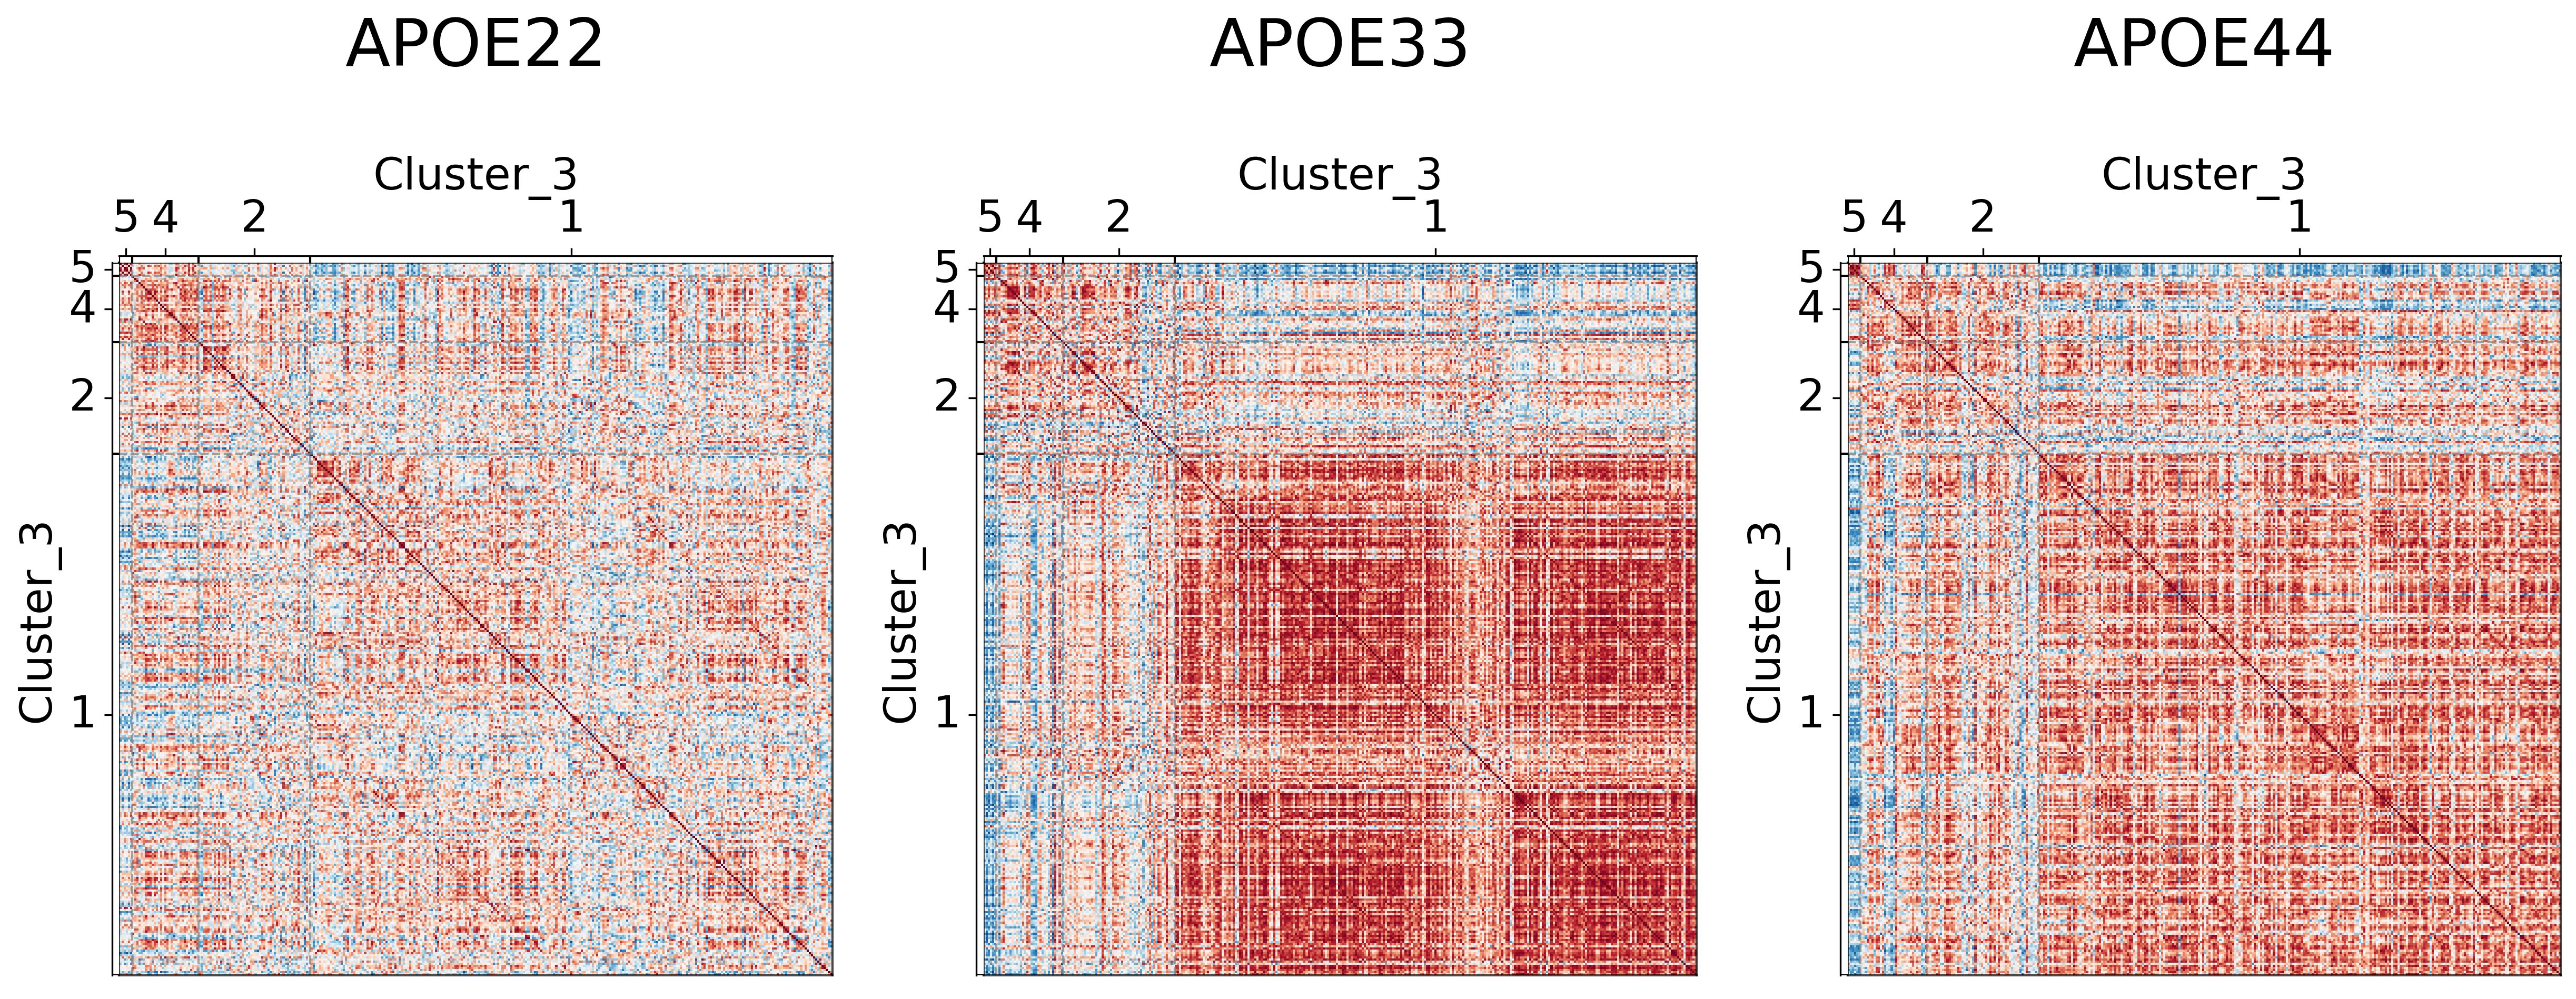

In [18]:
cl = pd.DataFrame(cluster_labels, columns=[f"Cluster_{i}" for i in range(1, 4)])

meta = pd.concat([node_labels, cl], axis=1)

meta.head()

## Plot to make sure nothing is wrong
for l in range(3):
    fig, ax = plt.subplots(
        ncols=3, 
        figsize=(20, 10), 
        #constrained_layout=True, 
        dpi=300,
        gridspec_kw=dict(width_ratios=[1, 1, 1])
    )
    
    for (i, genotype) in enumerate(vol_cor.keys()):
        gp.plot.adjplot(
            vol_cor[genotype], 
            ax=ax[i],
            vmin=-1,
            vmax=1,
            meta=meta,
            group=[f'Cluster_{l+1}'],
        )
        ax[i].set_title(f"{genotype}", pad=90, size=30)
        
    fig.savefig(f"./figures/2022-02-02-multigraph-clustering-level-{l + 1}.png", bbox_inches='tight')

## Comparing results to prior clusterings

In [19]:
mase = gp.embed.MultipleASE()
Vhat = mase.fit_transform([corr for _, corr in vol_cor.items()])
cluster = gp.cluster.DivisiveCluster(max_level=3)

cluster_labels = cluster.fit_predict(Vhat, fcluster=True)

cluster_label_df_ = pd.DataFrame(cluster_labels, columns=["cluster_level_1", "cluster_level_2", "cluster_level_3"])

In [20]:
from sklearn.metrics import adjusted_rand_score

In [21]:
adjusted_rand_score(cluster_label_df_.cluster_level_3, cluster_label_df.cluster_level_3)

0.6562743402239853